In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipdb
import platform
import h5py
import time
import scipy.io
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline

# MRI imports
# -----------
import nibabel as nb
import cortex

cmap = 'BuBkRd'
cmap_steps = 255
vmin,vmax = -1,1

# define colormap
def get_col(data,cmap,vmin,vmax,cmap_steps):

    base = cortex.utils.get_cmap(cmap)
    val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
    colmap = colors.LinearSegmentedColormap.from_list(  'my_colmap',
                                                        base(val),
                                                        N = cmap_steps)

    vrange = float(vmax) - float(vmin)
    norm_data = ((data-float(vmin))/vrange)*cmap_steps
    color_val = colmap(norm_data.astype(int))
    
    return(color_val)

In [2]:
# Define analysis parameters
# --------------------------
with open('/home/ada/projects/retino_HCP/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
base_dir = analysis_info["{}_base_folder".format(platform.uname()[1])] 
subject = '999999'
fit_model = 'gauss'            
mask_dir= 'all'

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11

subjects =['999999']



In [6]:
pprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan

nprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan

pprf_prop           = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan

nprf_prop           = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan


rois_subcortical = ['Ca', 'Pu','SNc', 'SNr','GPe','GPi']    
for sub_roi_num, sub_roi in enumerate(rois_subcortical):
    for subject_num, subject in enumerate(subjects):
        
        h5_dir = opj(base_dir,'pp_data','999999_bars_lisa',fit_model,'h5')

        data_hemi = []
        for hemi in ['L', 'R']:

            folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
            h5_file = h5py.File(opj(h5_dir,'{sub_roi}.h5'.format(sub_roi = sub_roi)), "r")
            in_file = opj("prf_deriv_{hemi}_{mask_dir}.func".format(hemi = hemi, mask_dir = mask_dir))
            data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]
            data = data[:,:].T
            data_hemi.append(data)
        
        data_LR = np.row_stack((data_hemi[0],data_hemi[1]))

        rsq_mask = data_LR[:,rsq_idx]
        rsq_mat = data_LR[:,rsq_idx]
        rsq_mat = rsq_mat[~np.isnan(rsq_mask)]
        sign_mat = data_LR[:,sign_idx]
        sign_mat = sign_mat[~np.isnan(rsq_mask)]
        pprf_rsqr = rsq_mat[sign_mat>0.0]
        nprf_rsqr = rsq_mat[sign_mat<0.0]
        nprf_rsqr = nprf_rsqr*-1.0
        
        pprf_rsqr_mean[subject_num,sub_roi_num] = np.nanmean(pprf_rsqr,axis = 0)
        pprf_rsqr_std[subject_num,sub_roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)
        pprf_rsqr_sem[subject_num,sub_roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)/np.sqrt(pprf_rsqr.shape[0])
        
        nprf_rsqr_mean[subject_num,sub_roi_num] = np.nanmean(nprf_rsqr,axis = 0)
        nprf_rsqr_std[subject_num,sub_roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)
        nprf_rsqr_sem[subject_num,sub_roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)/np.sqrt(nprf_rsqr.shape[0])
        
        pprf_prop[subject_num,sub_roi_num] = np.nansum(sign_mat==1)/sign_mat.shape[0]
        nprf_prop[subject_num,sub_roi_num] = (np.nansum(sign_mat==-1)/sign_mat.shape[0])*-1.0

In [7]:
def plot_fig2B():
    
   
    all_sub2draw = [0]
    
    # define figure
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    ax0 = fig.add_subplot(grid[0:6, 0:1])
    ax0.axis('off')
    ax1 = fig.add_subplot(grid[0:2, 2])
    ax2 = fig.add_subplot(grid[0:2, 3])


    # Settings
    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}
    
    ymin1,ymax1 = -1,1
    ymin2,ymax2 = -1,1
    y_tick_num1 = 5 
    y_tick_num2 = 5 

    sub_rois_len = np.arange(len(rois_subcortical))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75


    axs = ['ax1','ax2']
    
    # Titles 
    ax1.set_title('subcortical areas')
    ax2.set_title('subcortical areas')
    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)

    # Y label
    ax1.set_ylabel('pRF R\u00b2',axis_label_font)
    ax2.set_ylabel('pRF\npolarity ratio (%)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)


    # Y Tick label
    y_tick_label1 = []
    for t in zip(np.abs(y_tick1)):y_tick_label1.append('%1.2g'%t)
    y_tick_label2 = []
    for t in zip(np.abs(y_tick2)):y_tick_label2.append('%1.2g'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)

    # X Ticks
    ax1.set_xticks(sub_rois_len)
    ax2.set_xticks(sub_rois_len)


    # X lim
    ax1.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)
    ax2.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)

    # X Ticks Label
    ax1.set_xticklabels(rois_subcortical,**axis_tick_font,rotation = 45)
    ax2.set_xticklabels(rois_subcortical,**axis_tick_font,rotation = 45)

    # zero lines
    line_x_sub = np.arange(sub_rois_len[0]-1,sub_rois_len[-1]+2)
    ax1.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax2.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)
   
    # text legend
    sub_text_x = sub_rois_len[-1]+1 - (sub_rois_len[-1]+1)*0.05
    ax1.text(sub_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax1.text(sub_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(sub_text_x, 0.5, '+pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(sub_text_x, -0.5, '-pRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
   
    # define bar distance and width
    dist_sub = 0.15 * (3.0/len(all_sub2draw))
    width_sub = 0.15 * (3.0/len(all_sub2draw))

    # Plot all data
    # -------------
            
    for sub2draw_num,sub2draw in enumerate(all_sub2draw):
        rois_sub = [0,1,2,3,4,5]

        # +pRF/-pRF R2 x values
        ax1_x = np.arange(len(rois_sub))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))

        # +pRF R2
        ax1_y = pprf_rsqr_mean[sub2draw,rois_sub]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_sub)

        if sub2draw == 184:
            ax1_yerr = pprf_rsqr_std[sub2draw,rois_sub]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # -pRF R2
        ax1_y = nprf_rsqr_mean[sub2draw,rois_sub]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_sub)
        
        if sub2draw == 184:
            ax1_yerr = nprf_rsqr_std[sub2draw,rois_sub]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
           

        # +pRF/-pRF ratio x values
        ax2_x = np.arange(len(rois_sub))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))

        # +pRF ratio
        ax2_y = pprf_prop[sub2draw,rois_sub]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_sub)
        
        if sub2draw == 184:
            ax2_yerr = pprf_prop_std[sub2draw,rois_sub]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            
        # -pRF ratio
        ax2_y = nprf_prop[sub2draw,rois_sub]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_sub)
        if sub2draw == 184:
            ax2_yerr = nprf_prop_std[sub2draw,rois_sub]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            

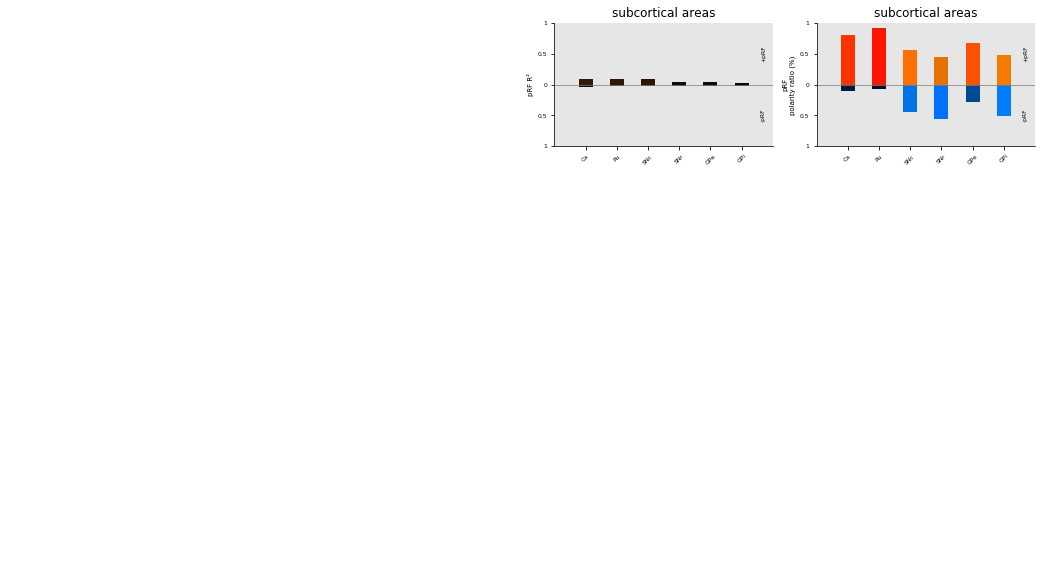

In [8]:
plot_fig2B()
img_dir = '/home/ada/projects/retino_HCP/post_fit/notebooks/figs/FigureSubcortex/'
try: os.makedirs(img_dir)
except: pass
plt.savefig("{imdir}polarity_res_bars_subrois.pdf".format(imdir = img_dir),facecolor='w')

In [9]:
#Subcortical areas PPRF and NPRF
rois_sub = [0,1,2,3,4,5]
subject2print_num = [0]
for subject_num in subject2print_num:
    
    prf_r2_mean    = np.nanmean(pprf_rsqr_mean[subject_num,rois_sub])
    prf_r2_std     = np.nanstd(pprf_rsqr_mean[subject_num,rois_sub],axis=0,ddof=1)
    prf_prop_mean  = np.nanmean(pprf_prop[subject_num,rois_sub])
    prf_prop_std   = np.nanstd(pprf_prop[subject_num,rois_sub],axis=0,ddof=1)

    print("Subcortical areas PPRF: {} ({}): +pPR R\u00b2 = {:1.2f} ± {:1.2f}, +pRF ratio: {:1.1f} ± {:1.1f}%".format(   subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))
                                                                                                                     
                                                                                                                     
                                                                                                                     
                                                                                                                     
    prf_r2_mean_neg   = np.nanmean(nprf_rsqr_mean[subject_num,rois_sub])
    prf_r2_std_neg    = np.nanstd(nprf_rsqr_mean[subject_num,rois_sub],axis=0,ddof=1)
    prf_prop_mean_neg = np.nanmean(nprf_prop[subject_num,rois_sub])
    prf_prop_std_neg  = np.nanstd(nprf_prop[subject_num,rois_sub],axis=0,ddof=1)
    
    print("Subcortical areas NPRF: {} ({}): -pPR R\u00b3 = {:1.2f} ± {:1.2f}, -pRF ratio: {:1.1f} ± {:1.1f}%".format(subjects[subject_num],
                                                                                                                     subject_num,
                                                                                                                     -prf_r2_mean_neg,
                                                                                                                     prf_r2_std_neg,
                                                                                                                     -prf_prop_mean_neg*100,
                                                                                                                     prf_prop_std_neg*100))                                                                                                                    

Subcortical areas PPRF: 999999 (0): +pPR R² = 0.06 ± 0.03, +pRF ratio: 64.6 ± 18.7%
Subcortical areas NPRF: 999999 (0): -pPR R³ = 0.03 ± 0.00, -pRF ratio: 32.9 ± 20.8%
